# Import library

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
tf.disable_v2_behavior()
import scipy.io as sio
import numpy as np
import numpy.matlib
import time
import os
import h5py

os.environ['CUDA_VISIBLE_DEVICES'] = '1'
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1 / 4;
#-My imports
from utils import signalprocessing as sig
# from utils.VCC_signal_creation import circshift,self_floor,VCC_siganal_creation,self_floor1,tf_sos
from  skimage.metrics import peak_signal_noise_ratio,structural_similarity


Instructions for updating:
non-resource variables are not supported in the long term


# Correlation function

In [2]:
def circshift(matrix_ori,shiftnum1,shiftnum2):
    c,h,w = matrix_ori.shape
    matrix_new=np.zeros_like(matrix_ori)
    for k in range(c):
        u=matrix_ori[k]
        if shiftnum1 < 0:
            u = np.vstack((u[-shiftnum1:,:],u[:-shiftnum1,:]))
        else:
            u = np.vstack((u[(h-shiftnum1):,:],u[:(h-shiftnum1),:]))
        if shiftnum2 > 0:
            u = np.hstack((u[:, (w - shiftnum2):], u[:, :(w - shiftnum2)]))
        else:
            u = np.hstack((u[:,-shiftnum2:],u[:,:-shiftnum2]))
        matrix_new[k]=u
    return matrix_new

def self_floor1(data1):
    data=np.copy(data1)
    I,J,K = data.shape
    for i in range(K):
        data[:,:,i] = np.flipud(data[:,:,i])#duiying de
        data[:,:,i] = np.fliplr(data[:,:,i])
    return data

def VCC_siganal_creation(kspace):
    # VCC_signals=np.conj(self_floor1(np.copy(kspace)))
    VCC_signals=np.copy(kspace)
    # kspace_vcc=np.concatenate((kspace,VCC_signals),axis=-2)
    return VCC_signals



def weight_variable(shape,vari_name):                   
    initial = tf.truncated_normal(shape, stddev=0.1,dtype=tf.float32)
    return tf.Variable(initial,name = vari_name)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape,dtype=tf.float32)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

def conv2d_dilate(x, W,dilate_rate):
    return tf.nn.convolution(x, W,padding='VALID',dilation_rate = [1,dilate_rate])

fft2c_raki  = lambda x: sig.fft(sig.fft(x,0),1)
ifft2c_raki = lambda x: sig.ifft(sig.ifft(x,0),1)


# MW-RAKI training function

In [3]:
ERRO_NOW=[]
def learning(ACS_input,target_input,accrate_input,sess):


    input_ACS = tf.placeholder(tf.float32, [1, ACS_dim_X,ACS_dim_Y,ACS_dim_Z])
    input_Target = tf.placeholder(tf.float32, [1, target_dim_X,target_dim_Y,target_dim_Z])
    
    Input = tf.reshape(input_ACS, [1, ACS_dim_X, ACS_dim_Y, ACS_dim_Z])

    [target_dim0,target_dim1,target_dim2,target_dim3] = np.shape(target)

    W_conv1 = weight_variable([kernel_x_1, kernel_y_1, ACS_dim_Z, layer1_channels],'W1') 
    h_conv1 = tf.nn.relu(conv2d_dilate(Input, W_conv1,accrate_input)) 

#     W_conv2 = weight_variable([kernel_x_2*1, kernel_y_2, layer1_channels, layer2_channels],'W2')
#     h_conv2 = tf.nn.relu(conv2d_dilate(h_conv1, W_conv2,accrate_input))

    W_conv3 = weight_variable([kernel_last_x, kernel_last_y, layer1_channels, target_dim3],'W3')
    h_conv3 = conv2d_dilate(h_conv1, W_conv3,accrate_input)

    error_norm = tf.norm(input_Target - h_conv3)
    # error_norm = tf.norm(input_Target[:,:,0:every_space,:] - h_conv3[:,:,0:every_space,:])+ (1e-2)*tf.norm(input_Target[:,:,every_space+1:every_space*2,:] - h_conv3[:,:,every_space+1:every_space*2,:])
    # error_norm = tf.norm(input_Target[0,:,:,:] - h_conv3[0,:,:,:])+ (1e-2)*tf.norm(input_Target[1,:,:,:] - h_conv3[1,:,:,:])
    # error_norm = tf.norm(tf_sos(input_Target[:,:,0:every_space,:]) - tf_sos(h_conv3[:,:,0:every_space,:]))+ (1e-2)*tf.norm(tf_sos(input_Target[:,:,every_space+1:every_space*2,:]) - tf_sos(h_conv3[:,:,every_space+1:every_space*2,:]))
    train_step = tf.train.AdamOptimizer(LearningRate).minimize(error_norm)

    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)

    error_prev = 1 
    for i in range(MaxIteration):
        
        sess.run(train_step, feed_dict={input_ACS: ACS_input, input_Target: target_input})
        if i % 100 == 0:
            error_now=sess.run(error_norm,feed_dict={input_ACS: ACS_input, input_Target: target_input})
            ERRO_NOW.append(error_now)
            sio.savemat('results/error_now.mat',{'Img':ERRO_NOW})
            print('The',i,'th iteration gives an error',error_now)                         
   
    error = sess.run(error_norm,feed_dict={input_ACS: ACS_input, input_Target: target_input})
    return [sess.run(W_conv1),sess.run(W_conv3),error]


def cnn_3layer(input_kspace,w1,b1,b2,w3,b3,acc_rate,sess):
    h_conv1 = tf.nn.relu(conv2d_dilate(input_kspace, w1,acc_rate)) 
    # h_conv2 = tf.nn.relu(conv2d_dilate(h_conv1, w2,acc_rate))
    h_conv3 = conv2d_dilate(h_conv1, w3,acc_rate)
    return sess.run(h_conv3)           


# Data preprocessing

In [4]:
image_coils_truth  = sio.loadmat('data/img_grappa_32chan.mat')['IMG']#(188, 236, 32) 图像域的图
# image_coils_truth  = sio.loadmat('data/256DATA2/1.mat')['Img']#(188, 236, 32) 图像域的图

# image_coils_truth  =image_coils_truth1['real']+image_coils_truth1['imag']*1
# image_coils_truth=np.transpose(image_coils_truth,(2,1,0))
# image_coils_truth  = sio.loadmat('data/2DMREPPA2.mat')['Img']
#################################################################
normalize = 1/np.max(abs(image_coils_truth[:]))
image_coils_truth = np.multiply(image_coils_truth, normalize)
kspace_truth_raki  = fft2c_raki(image_coils_truth)
# kspace_truth_raki=self_floor1(kspace_truth_raki)
novcc_kspace_truth_raki=np.copy(kspace_truth_raki)
[M,N,C] = kspace_truth_raki.shape
weight=np.repeat(sio.loadmat('data/weight/weight9.mat')['weight'][:,:,np.newaxis],C,axis=-1)
weight1=np.repeat(sio.loadmat('data/weight/weight9.mat')['weight'][:,:,np.newaxis],C,axis=-1)
# weight2=np.repeat(sio.loadmat('data/weight/weight9.mat')['weight'][:,:,np.newaxis],C,axis=-1)

# Setting   parameters

In [5]:
Rx     = 1
all_Ry = [6]

acsx     = M
# all_acsy = [20,24,30,36,40]
all_acsy = [40]

#### Network Parameters ####
all_kernel_x_1 = [5]
all_kernel_y_1 = [2]

all_kernel_x_2 = [1]
all_kernel_y_2 = [1]
# all_kernel_y_2 = [3]

all_kernel_last_x = [3]
all_kernel_last_y = [2]

all_layer1_channels = [C]
all_layer2_channels = [8]

MaxIteration = 250  #Default = 1000
LearningRate = 1e-3  #Default = 3e-3

all_kspace_recons = np.zeros((M,N,2*C),dtype = complex)

kernel_x_1 = all_kernel_x_1[0]  # Default = 5
kernel_y_1 = all_kernel_y_1[0]  # Default = 2

kernel_x_2 = all_kernel_x_2[0]  # Default = 1
kernel_y_2 = all_kernel_y_2[0]  # Default = 1

kernel_last_x = all_kernel_last_x[0]  # Default = 3
kernel_last_y = all_kernel_last_y[0]  # Default = 2

layer1_channels = all_layer1_channels[0]  # Default = 32
layer2_channels = all_layer2_channels[0]  # Default = 8

Ry = all_Ry[0]
acsy = all_acsy[0]  # first acs is 20
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("R: %d || acs: %d  " % (Ry, acsy))
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
R: 6 || acs: 40  
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


# Mutiply the weights

In [6]:
acsregionX = np.arange(M // 2 - acsx // 2, M // 2 + acsx // 2)
acsregionY = np.arange(N // 2 - acsy // 2, N // 2 + acsy // 2)

kspace_raki_undersampled_withacs = np.zeros((M, N, C), dtype=complex)  # 188*236*32

kspace_raki_undersampled_withacs[::Rx, ::Ry, :] = kspace_truth_raki[::Rx, ::Ry,
                                                  :]  # sample every 5 line only 1 188*236*32
kspace_raki_undersampled_withacs[acsregionX[0]:acsregionX[acsx - 1] + 1, acsregionY[0]:acsregionY[acsy - 1] + 1,
:] = kspace_truth_raki[acsregionX[0]:acsregionX[acsx - 1] + 1, acsregionY[0]:acsregionY[acsy - 1] + 1,
     :]  # after sample copy the ACS regin


kspace = np.copy(kspace_raki_undersampled_withacs)

kspace_no_nor = np.copy(kspace)

normalize = 0.15 / np.max(abs(kspace[:]))
kspace = np.multiply(kspace, normalize)


kspace_0_w = np.copy(kspace_no_nor)
kspace_1_w = np.copy(kspace_no_nor)
# kspace_2_w = np.copy(kspace_no_nor)

kspace_0_w_a = np.multiply(kspace_0_w, weight);
kspace_0_w_a = np.copy(kspace_0_w_a)

# sio.savemat('results/w9GT.mat', {'Img':kspace_0_w_a})

kspace_1_w_a = np.multiply(kspace_1_w, weight1);
kspace_1_w_a = np.copy(kspace_1_w_a)
# kspace_2_w_a = np.multiply(kspace_1_w, weight2);kspace_1_w_a = np.copy(kspace_2_w_a)

# Auto searching ACS

In [7]:
no_ACS_flag = 0;
[m1, n1, no_ch] = np.shape(kspace)
no_inds = 1

kspace_all = np.copy(kspace);
kx = np.transpose(np.int32([(range(1, m1 + 1))]))  # 1 to 188
ky = np.int32([(range(1, n1 + 1))])  # 1 to 236

kspace = np.copy(kspace_all)
mask = np.squeeze(np.matlib.sum(np.matlib.sum(np.abs(kspace), 0), 1)) > 0;  # y轴大于零的地方236
picks = np.where(mask == 1);  # ·[0 5 10 15 ]
kspace = kspace[:, np.int32(picks[0][0]):n1 + 1, :]
kspace_all = kspace_all[:, np.int32(picks[0][0]):n1 + 1, :]

# kspace_NEVER_TOUCH = VCC_siganal_creation(np.copy(kspace_all))

mask = np.squeeze(np.matlib.sum(np.matlib.sum(np.abs(kspace), 0), 1)) > 0;  # y轴大小0的地方
picks = np.where(mask == 1);  # 得到为1的索引0 5 10 15
d_picks = np.diff(picks, 1)
indic = np.where(d_picks == 1);  # 得到值为1的索引

mask_x = np.squeeze(np.matlib.sum(np.matlib.sum(np.abs(kspace), 2), 1)) > 0;  # x轴方向
picks_x = np.where(mask_x == 1);  ##[0 1 2 3 4 ....187]
x_start = picks_x[0][0]  # 0
x_end = picks_x[0][-1]  # 187

if np.size(indic) == 0:
    no_ACS_flag = 1;
    print('No ACS signal in input data, using individual ACS file.')
    matfn = 'ACS.mat'
    ACS = sio.loadmat(matfn)
    ACS = ACS['ACS']
    [ACS_dim_X, ACS_dim_Y, ACS_dim_Z] = np.shape(ACS)
    ACS_re = np.zeros([ACS_dim_X, ACS_dim_Y, ACS_dim_Z * 2])
    ACS_re[:, :, 0:no_ch] = np.real(ACS)
    ACS_re[:, :, no_ch:no_ch * 2] = np.imag(ACS)
else:
    no_ACS_flag = 0;
    print('ACS signal found in the input data')
    indic = indic[1][:]  # [22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40] 两维也是最后一维
    center_start = picks[0][indic[0]];  # 108
    center_end = picks[0][indic[-1] + 1];  # 128

    ACS_0_w = kspace_0_w_a[x_start:x_end + 1, center_start:center_end + 1, :]
    ACS_1_w = kspace_1_w_a[x_start:x_end + 1, center_start:center_end + 1, :]
    # ACS_2_w = kspace_2_w_a[x_start:x_end + 1, center_start:center_end + 1, :]

    ACS = np.concatenate([ACS_0_w[np.newaxis, :, :, :], ACS_1_w[np.newaxis, :, :, :]], axis=0)
    [ACS_batch, ACS_dim_X, ACS_dim_Y, ACS_dim_Z] = np.shape(ACS)  # [188 20 32]
    ACS_re = np.zeros([ACS_batch, ACS_dim_X, ACS_dim_Y, ACS_dim_Z * 2])  # 堆叠[188 20 64 ] 之后填入实部和虚部
    ACS_re[:, :, :, 0:no_ch] = np.real(ACS)
    ACS_re[:, :, :, no_ch:no_ch * 2] = np.imag(ACS)

ACS signal found in the input data


In [8]:
acc_rate = d_picks[0][0]  # 5
no_channels = ACS_dim_Z * 2  # 64

w1_all = np.zeros([kernel_x_1, kernel_y_1, no_channels, layer1_channels, no_channels * ACS_batch],
                  dtype=np.float32)  # [5 2 64 32 64]
w2_all = np.zeros([kernel_x_2, kernel_y_2, layer1_channels, layer2_channels, no_channels * ACS_batch],
                  dtype=np.float32)  # [1 1 32 8 64]
w3_all = np.zeros([kernel_last_x, kernel_last_y, layer1_channels, acc_rate - 1, no_channels * ACS_batch],
                  dtype=np.float32)  # [3 2 8 4 64]

b1_flag = 0;
b2_flag = 0;
b3_flag = 0;

if (b1_flag == 1):
    b1_all = np.zeros([1, 1, layer1_channels, no_channels]);
else:
    b1 = []

if (b2_flag == 1):
    b2_all = np.zeros([1, 1, layer2_channels, no_channels])
else:
    b2 = []

if (b3_flag == 1):
    b3_all = np.zeros([1, 1, layer3_channels, no_channels])
else:
    b3 = []

target_x_start = np.int32(np.ceil(kernel_x_1 / 2) + np.floor(kernel_last_x / 2) - 1);  # 3
target_x_end = np.int32(ACS_dim_X - target_x_start - 1);  # 184

time_ALL_start = time.time()

[ACS_batch, ACS_dim_X, ACS_dim_Y, ACS_dim_Z] = np.shape(ACS_re)
ACS = np.reshape(ACS_re, [ACS_batch, ACS_dim_X, ACS_dim_Y, ACS_dim_Z])  # [188 20 64]
ACS = np.float32(ACS)

target_y_start = np.int32((np.ceil(kernel_y_1 / 2) - 1) + (np.ceil(kernel_last_y / 2) - 1)) * acc_rate;  # acc_rate=5
target_y_end = ACS_dim_Y - np.int32((np.floor(kernel_y_1 / 2) + np.floor(kernel_last_y / 2))) * acc_rate - 1;

target_dim_X = target_x_end - target_x_start + 1  # 182
target_dim_Y = target_y_end - target_y_start + 1  # 10
target_dim_Z = acc_rate - 1



#  Network start learning

In [9]:
print('begin learning!')
time_Learn_start = time.time()

errorSum = 0;
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1 / 4;

for ii_for in range(ACS_batch):
    for ind_c in range(ACS_dim_Z):  # 64 ACS=·188 20 64「

        sess = tf.Session(config=config)
        # set target lines
        target = np.zeros([ACS_batch, target_dim_X, target_dim_Y, target_dim_Z])  # [1 182 10 4]
        print('learning channel #', ind_c + 1)  # 总共64 迭代第一通道
        time_channel_start = time.time()

        for ind_acc in range(acc_rate - 1):
            target_y_start = np.int32(
                (np.ceil(kernel_y_1 / 2) - 1) + (np.ceil(kernel_last_y / 2) - 1)) * acc_rate + ind_acc + 1
            target_y_end = ACS_dim_Y - np.int32(
                (np.floor(kernel_y_1 / 2) + np.floor(kernel_last_y / 2))) * acc_rate + ind_acc
            # target_y_end_0=target_y_end-12-41
            every_space = int((target_y_end + 1 - target_y_start) / 2)
            # first_fild=ACS[0,target_x_start:target_x_end + 1, target_y_start:target_y_end +1,ind_c];
            # second_fild=ACS[1,target_x_start:target_x_end + 1, target_y_start:target_y_end +1,ind_c];
            three_fild = ACS[0, target_x_start:target_x_end + 1, target_y_start:target_y_end + 1, ind_c];
            four_fild = ACS[1, target_x_start:target_x_end + 1, target_y_start:target_y_end + 1, ind_c];
            # five_fild=ACS[2,target_x_start:target_x_end + 1, target_y_start:target_y_end +1,ind_c];
            truth_ACS = np.concatenate([three_fild[np.newaxis, :, :], four_fild[np.newaxis, :, :]], axis=0)
            target[:, :, :, ind_acc] = truth_ACS
            # target[0,:,:,ind_acc] = ACS[0,target_x_start:target_x_end + 1, target_y_start:target_y_end +1,ind_c];

        # learning
        # if ind_c == ACS_dim_Z*2 + 1:
        #     ii =
        print('The blocks of study%d', ii_for)
        [w1, w3, error] = learning(np.reshape(ACS[ii_for, ...], [1, ACS_dim_X, ACS_dim_Y, ACS_dim_Z]),
                                   np.reshape(target[ii_for, ...], [1, target_dim_X, target_dim_Y, target_dim_Z]),
                                   acc_rate, sess)
        w1_all[:, :, :, :, ind_c + ACS_dim_Z * ii_for] = w1
        # w2_all[:,:,:,:,ind_c+ACS_dim_Z*ii_for] = w2
        w3_all[:, :, :, :, ind_c + ACS_dim_Z * ii_for] = w3
        time_channel_end = time.time()
        print('Time Cost:', time_channel_end - time_channel_start, 's')
        print('Norm of Error = ', error)
        errorSum = errorSum + error

        sess.close()
        tf.reset_default_graph()

time_Learn_end = time.time();

print('lerning step costs:', (time_Learn_end - time_Learn_start) / 60, 'min')


begin learning!
learning channel # 1
The blocks of study%d 0
The 0 th iteration gives an error 0.39410302
The 100 th iteration gives an error 0.09257887
The 200 th iteration gives an error 0.065806225
Time Cost: 2.271315813064575 s
Norm of Error =  0.059380107
learning channel # 2
The blocks of study%d 0
The 0 th iteration gives an error 0.47710207
The 100 th iteration gives an error 0.09951827
The 200 th iteration gives an error 0.069030814
Time Cost: 0.44005632400512695 s
Norm of Error =  0.06140594
learning channel # 3
The blocks of study%d 0
The 0 th iteration gives an error 0.35113418
The 100 th iteration gives an error 0.08551971
The 200 th iteration gives an error 0.066303656
Time Cost: 0.456634521484375 s
Norm of Error =  0.06129146
learning channel # 4
The blocks of study%d 0
The 0 th iteration gives an error 0.33640367
The 100 th iteration gives an error 0.06342268
The 200 th iteration gives an error 0.04617068
Time Cost: 0.44849658012390137 s
Norm of Error =  0.04233976
lear

The 100 th iteration gives an error 0.09929274
The 200 th iteration gives an error 0.06879928
Time Cost: 0.4431619644165039 s
Norm of Error =  0.061231464
learning channel # 35
The blocks of study%d 0
The 0 th iteration gives an error 0.42333853
The 100 th iteration gives an error 0.09028122
The 200 th iteration gives an error 0.06958392
Time Cost: 0.4439427852630615 s
Norm of Error =  0.064194515
learning channel # 36
The blocks of study%d 0
The 0 th iteration gives an error 0.2979561
The 100 th iteration gives an error 0.058778863
The 200 th iteration gives an error 0.04440624
Time Cost: 0.4493868350982666 s
Norm of Error =  0.041147716
learning channel # 37
The blocks of study%d 0
The 0 th iteration gives an error 0.37932333
The 100 th iteration gives an error 0.08843659
The 200 th iteration gives an error 0.06715735
Time Cost: 0.4403524398803711 s
Norm of Error =  0.061718218
learning channel # 38
The blocks of study%d 0
The 0 th iteration gives an error 0.39919248
The 100 th itera

Time Cost: 0.45082783699035645 s
Norm of Error =  0.060135774
learning channel # 4
The blocks of study%d 1
The 0 th iteration gives an error 0.40547845
The 100 th iteration gives an error 0.062345464
The 200 th iteration gives an error 0.045816064
Time Cost: 0.4555387496948242 s
Norm of Error =  0.04208582
learning channel # 5
The blocks of study%d 1
The 0 th iteration gives an error 0.33880064
The 100 th iteration gives an error 0.08745782
The 200 th iteration gives an error 0.066536635
Time Cost: 0.45046234130859375 s
Norm of Error =  0.061081275
learning channel # 6
The blocks of study%d 1
The 0 th iteration gives an error 0.43594575
The 100 th iteration gives an error 0.0940144
The 200 th iteration gives an error 0.06490698
Time Cost: 0.45864415168762207 s
Norm of Error =  0.058138553
learning channel # 7
The blocks of study%d 1
The 0 th iteration gives an error 0.3614494
The 100 th iteration gives an error 0.073797464
The 200 th iteration gives an error 0.05634741
Time Cost: 0.451

The 100 th iteration gives an error 0.08771926
The 200 th iteration gives an error 0.0664562
Time Cost: 0.4511547088623047 s
Norm of Error =  0.060857616
learning channel # 38
The blocks of study%d 1
The 0 th iteration gives an error 0.3860699
The 100 th iteration gives an error 0.08521508
The 200 th iteration gives an error 0.060741644
Time Cost: 0.4441087245941162 s
Norm of Error =  0.054924518
learning channel # 39
The blocks of study%d 1
The 0 th iteration gives an error 0.28759417
The 100 th iteration gives an error 0.07091785
The 200 th iteration gives an error 0.05554368
Time Cost: 0.43771886825561523 s
Norm of Error =  0.051755596
learning channel # 40
The blocks of study%d 1
The 0 th iteration gives an error 0.32358018
The 100 th iteration gives an error 0.078606464
The 200 th iteration gives an error 0.06364987
Time Cost: 0.4565894603729248 s
Norm of Error =  0.059827145
learning channel # 41
The blocks of study%d 1
The 0 th iteration gives an error 0.3314599
The 100 th itera

# Reconstructing data perparation

In [10]:

kspace = np.copy(kspace_all)

over_samp = np.setdiff1d(picks, np.int32([range(0, n1, acc_rate)]))  # return in 1 not in second [108 109 --127]


kspace_und_0_w_a = kspace_0_w_a  # 还是欠采数据
kspace_und_0_w_a[:, over_samp, :] = 0;  # 欠采之后的数据把中心区域的值变为0

kspace_und_1_w_a = kspace_1_w_a;
kspace_und_1_w_a[:, over_samp, :] = 0;


kspace_und = np.copy(
    np.concatenate((kspace_und_0_w_a[np.newaxis, :, :, :], kspace_und_1_w_a[np.newaxis, :, :, :]), axis=0))  # 得到的容器

[dim_kspaceUnd_batch, dim_kspaceUnd_X, dim_kspaceUnd_Y, dim_kspaceUnd_Z] = np.shape(kspace_und)

kspace_und_re = np.zeros([dim_kspaceUnd_batch, dim_kspaceUnd_X, dim_kspaceUnd_Y, dim_kspaceUnd_Z * 2])
kspace_und_re[:, :, :, 0:dim_kspaceUnd_Z] = np.real(kspace_und)
kspace_und_re[:, :, :, dim_kspaceUnd_Z:dim_kspaceUnd_Z * 2] = np.imag(kspace_und)
kspace_und_re = np.float32(kspace_und_re)
kspace_und_re = np.reshape(kspace_und_re, [dim_kspaceUnd_batch, dim_kspaceUnd_X, dim_kspaceUnd_Y, dim_kspaceUnd_Z * 2])
kspace_und_re_all = np.copy(kspace_und_re)

kspace_recon = np.copy(kspace_und_re)

# Starting reconstruction Image

In [11]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1 / 4;

for iii in range(ACS_batch):
    for ind_c in range(0, no_channels):
        print('Reconstruting Channel #', ind_c + 1)

        sess = tf.Session(config=config)
        if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
            init = tf.initialize_all_variables()
        else:
            init = tf.global_variables_initializer()
        sess.run(init)

        # grab w and b
        w1 = np.float32(w1_all[:, :, :, :, ind_c + ACS_dim_Z * iii])
        # w2 = np.float32(w2_all[:,:,:,:,ind_c+ACS_dim_Z*iii])
        w3 = np.float32(w3_all[:, :, :, :, ind_c + ACS_dim_Z * iii])

        if (b1_flag == 1):
            b1 = b1_all[:, :, :, ind_c];
        if (b2_flag == 1):
            b2 = b2_all[:, :, :, ind_c];
        if (b3_flag == 1):
            b3 = b3_all[:, :, :, ind_c];

        res = cnn_3layer(
            np.reshape(kspace_und_re[iii, ...], [1, dim_kspaceUnd_X, dim_kspaceUnd_Y, dim_kspaceUnd_Z * 2]), w1, b1, b2,
            w3, b3, acc_rate, sess)
        target_x_end_kspace = dim_kspaceUnd_X - target_x_start;

        for ind_acc in range(0, acc_rate - 1):
            target_y_start = np.int32(
                (np.ceil(kernel_y_1 / 2) - 1) + np.int32(np.ceil(kernel_last_y / 2) - 1)) * acc_rate + ind_acc + 1;
            target_y_end_kspace = dim_kspaceUnd_Y - np.int32(
                (np.floor(kernel_y_1 / 2)) + np.floor(kernel_last_y / 2)) * acc_rate + ind_acc;
            kspace_recon[iii:iii + 1, target_x_start:target_x_end_kspace,
            target_y_start:target_y_end_kspace + 1:acc_rate, ind_c] = res[0, :, ::acc_rate, ind_acc]

        sess.close()
        tf.reset_default_graph()

Reconstruting Channel # 1
Reconstruting Channel # 2
Reconstruting Channel # 3
Reconstruting Channel # 4
Reconstruting Channel # 5
Reconstruting Channel # 6
Reconstruting Channel # 7
Reconstruting Channel # 8
Reconstruting Channel # 9
Reconstruting Channel # 10
Reconstruting Channel # 11
Reconstruting Channel # 12
Reconstruting Channel # 13
Reconstruting Channel # 14
Reconstruting Channel # 15
Reconstruting Channel # 16
Reconstruting Channel # 17
Reconstruting Channel # 18
Reconstruting Channel # 19
Reconstruting Channel # 20
Reconstruting Channel # 21
Reconstruting Channel # 22
Reconstruting Channel # 23
Reconstruting Channel # 24
Reconstruting Channel # 25
Reconstruting Channel # 26
Reconstruting Channel # 27
Reconstruting Channel # 28
Reconstruting Channel # 29
Reconstruting Channel # 30
Reconstruting Channel # 31
Reconstruting Channel # 32
Reconstruting Channel # 33
Reconstruting Channel # 34
Reconstruting Channel # 35
Reconstruting Channel # 36
Reconstruting Channel # 37
Reconstrut

# Keeping truth result

In [12]:
kspace_recon = np.squeeze(kspace_recon)
kspace_recon_complex = (kspace_recon[:, :, :, 0:np.int32(no_channels / 2)] + np.multiply(
    kspace_recon[:, :, :, np.int32(no_channels / 2):no_channels], 1j))

# kspace_recon_complex_0 = kspace_recon_complex[0, :, :, :]
# kspace_recon_complex_1 = kspace_recon_complex[1, :, :, :]

kspace_recon_complex_0_w_a = kspace_recon_complex[0, :, :, :]
kspace_recon_complex_1_w_a = kspace_recon_complex[1, :, :, :]
# kspace_recon_complex_2_w_a = kspace_recon_complex[2,:, :, :]


kspace_recon_complex_0_w_d = np.multiply(kspace_recon_complex_0_w_a, 1. / weight)
# kspace_recon_complex_0_w_d = np.multiply(kspace_recon_complex_0_w_a,1)
kspace_recon_complex_1_w_d = np.multiply(kspace_recon_complex_1_w_a, 1. / weight1)
# kspace_recon_complex_2_w_d = np.multiply(kspace_recon_complex_2_w_a,1./weight2)
# kspace_recon_all_nocenter[:,:,:] = np.copy(kspace_recon_complex);

if no_ACS_flag == 0:

    # kspace_recon_complex_0[:, center_start:center_end, :] = kspace_0[:,center_start:center_end,:]
    # kspace_recon_complex_1[:, center_start:center_end, :] = kspace_1[:,center_start:center_end,:]

    kspace_recon_complex_0_w_d[:, center_start:center_end, :] = kspace_0_w[:, center_start:center_end, :]
    sio.savemat('results/udwkspace.mat', {'Img': kspace_recon_complex_0_w_d})

    kspace_recon_complex_1_w_d[:, center_start:center_end, :] = kspace_1_w[:, center_start:center_end, :]
    # kspace_recon_complex_2_w_d[:,center_start:center_end,:]=kspace_2_w[:,center_start:center_end,:]

    kspace_recon_complex_0_w_d[weight == 0] = kspace_0_w[weight == 0]
    kspace_recon_complex_1_w_d[weight1 == 0] = kspace_1_w[weight1 == 0]
    # kspace_recon_complex_2_w_d[weight == 0] = kspace_2_w[weight1 == 0]

    print('ACS signal has been putted back')
    #

else:
    print('No ACS signal is putted into k-space')

# kspace_recon_all[:,:,:] = kspace_recon_complex1;
# combine_1=kspace_recon_complex_0
# combine_2=kspace_recon_complex_1
combine_3 = kspace_recon_complex_0_w_d
combine_4 = kspace_recon_complex_1_w_d

# combine_5 = kspace_recon_complex_2_w_d
# combine2_conj=self_floor1(np.conj(combine2))
combine = np.concatenate([combine_3, combine_4], axis=-1)  # combine=combine_3

sig.kerro(novcc_kspace_truth_raki, combine_3, acsregionY, acsy)
# kh = sig.rsos(combine_3, 2)
# GTh=sig.rsos(novcc_kspace_truth_raki, 2)
# kerro = GTh - kh
# kerro[:,acsregionY[0]:acsregionY[acsy-1]+1]=0
# sio.savemat('results/kerro.mat', {'Img': kerro})

# combine=(combine1+(1e-2)*combine2_conj)/np.sqrt(2)
# combine=(combine1+(1e-2)*combine2_conj)/np.sqrt(2)
# combine=combine1
all_kspace_recons[:, :, :] = combine
# all_kspace_recons[:,:,:,aa,bb,cc,dd,ee,ff,gg,hh,ii,jj] = kspace_recon_all

time_ALL_end = time.time()
print('All process costs ', (time_ALL_end - time_ALL_start) / 60, 'mins')
print('Error Average in Training is ', errorSum / no_channels)

ACS signal has been putted back
All process costs  1.771841581662496 mins
Error Average in Training is  0.1095473095192574


/home/lqg/anaconda3/envs/th/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/home/lqg/anaconda3/envs/th/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


# Display result

rmse: 5.581057273424001
psnr: 33.60943443611753
ssim 0.9655286587705022
MaxIteration 250


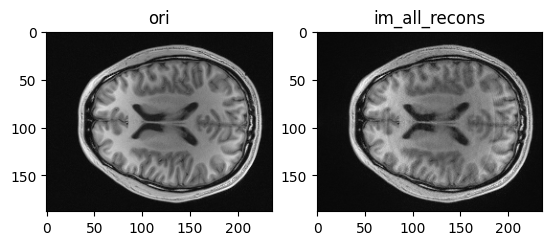

In [13]:
ablation_dims = [len(all_kernel_x_1),len(all_kernel_y_1),len(all_kernel_x_2),len(all_kernel_y_2),                len(all_kernel_last_x),len(all_kernel_last_y),len(all_layer1_channels),len(all_layer2_channels),                len(all_Ry),len(all_acsy)]
all_rmse   = np.zeros(ablation_dims)

# print(all_kspace_recons.shape)
# # sio.savemat('results/raki_ablation1.mat', results, oned_as='row')
# assert 0

all_recons = sig.rsos(ifft2c_raki(all_kspace_recons),2)
truth      = sig.rsos(ifft2c_raki(kspace_truth_raki),2)

truth   = np.expand_dims(np.transpose(sig.rsos(ifft2c_raki(novcc_kspace_truth_raki),-1),(0,1)),axis=0)
truth1   = np.expand_dims(np.transpose(sig.rsos(ifft2c_raki(novcc_kspace_truth_raki),-1),(1,0)),axis=0)

im_true=truth=truth/np.max(truth)
# im_true=sig.nor(truth)
# im_true=np.transpose(im_true,(1,0))
im_all_recons=all_recons/np.max(all_recons)
# im_all_recons=sig.nor(all_recons)
rmse=sig.rmse(np.squeeze(im_true),np.squeeze(im_all_recons))*100
psnr=peak_signal_noise_ratio(np.squeeze(im_true),np.squeeze(im_all_recons))
ssim=structural_similarity(np.squeeze(im_true),np.squeeze(im_all_recons))
print('rmse:',rmse)
print('psnr:',psnr)
print('ssim',ssim)
print('MaxIteration',MaxIteration)

plt.subplot(121)
plt.imshow( np.squeeze(im_true),cmap='gray',vmin=0,vmax=1)
plt.title('ori')
plt.subplot(122)
plt.imshow(np.squeeze(im_all_recons),cmap='gray',vmin=0,vmax=1)
plt.title('im_all_recons')
plt.show()